Number of datapoints in the dataset: 2240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 

<Figure size 800x550 with 0 Axes>

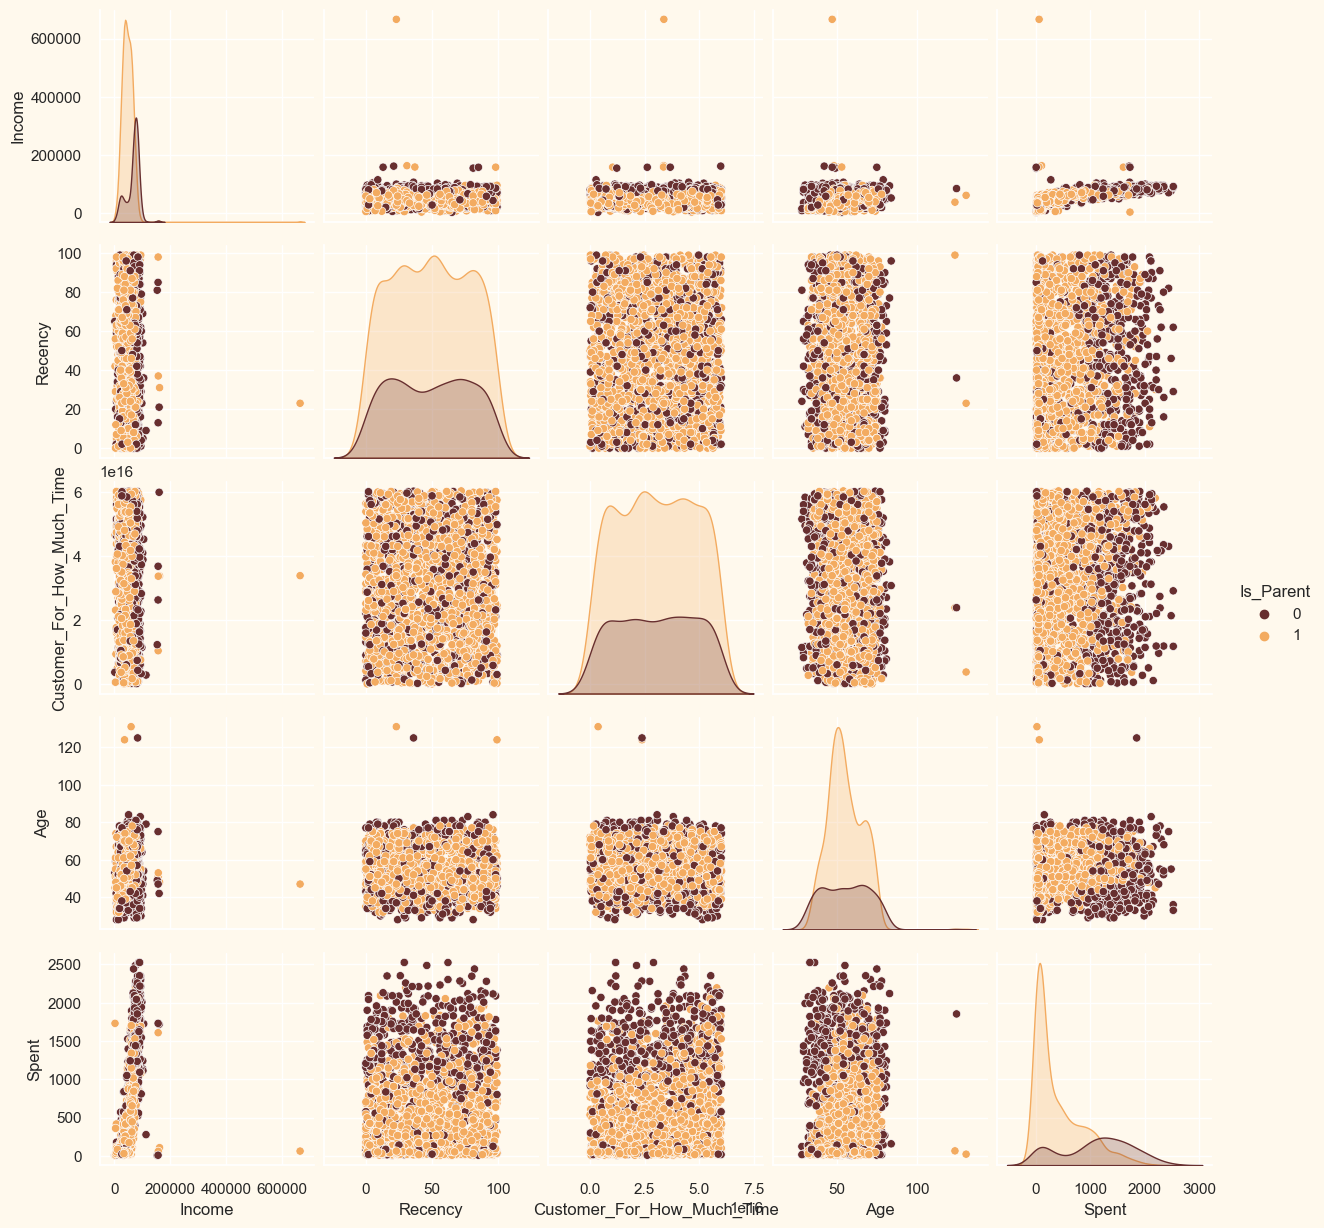

Following the elimination of the outliers, there are 2212 numbers of data points:
the dataset's categorical variables are: []
Now, all attributes are numerical.
 Now, every feature is scaled 
Dataframe to be applied in further modelling:


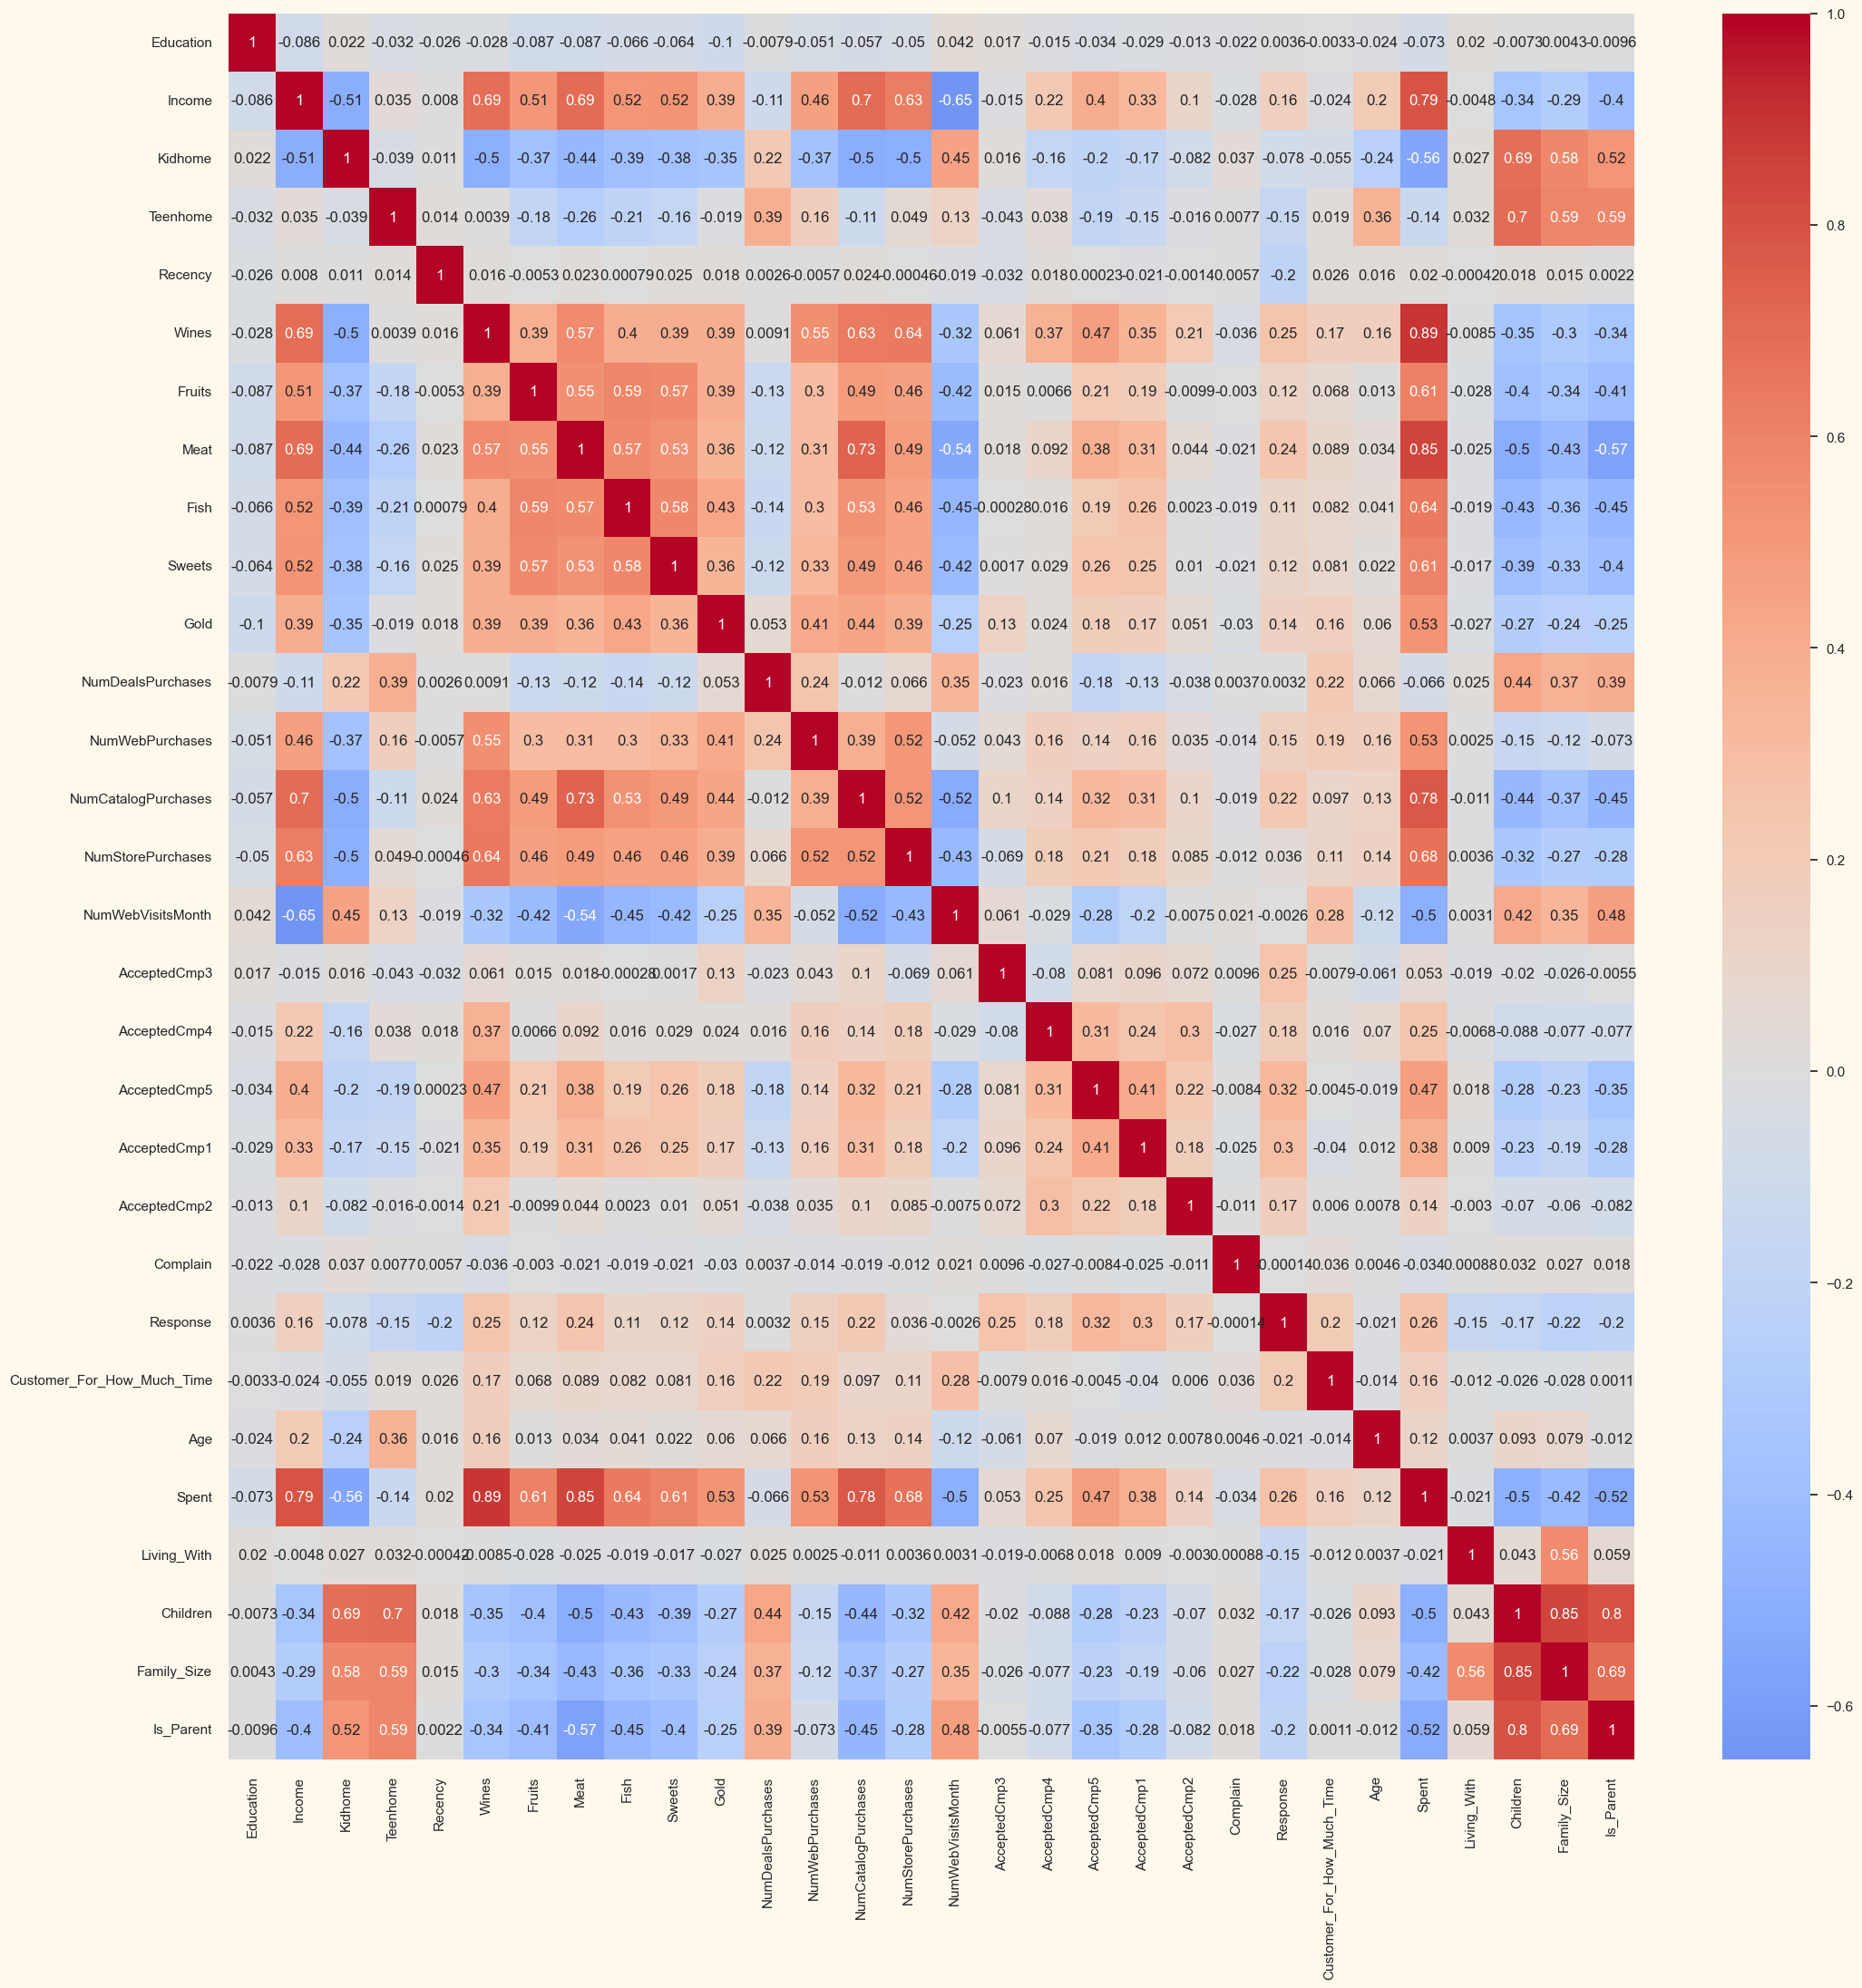

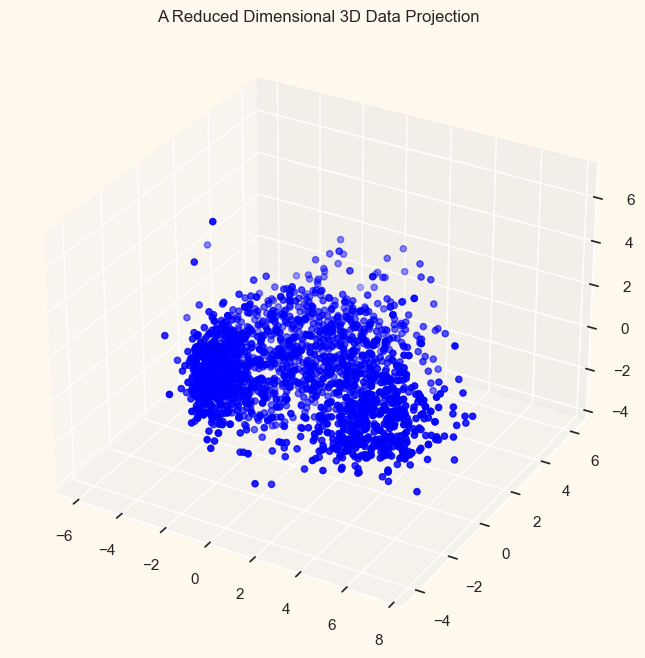

The amount of clusters to generate will be determined using the elbow method:


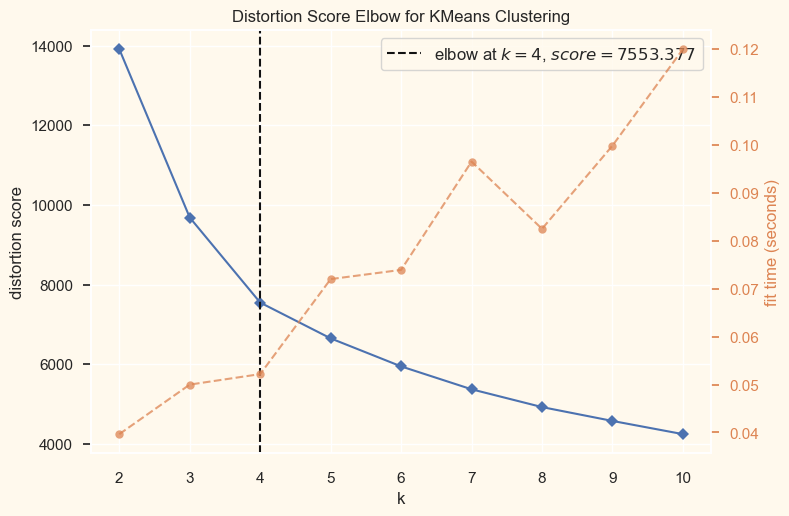

Silhouette Score for Agglomerative Clustering: 0.35550301100146425
Silhouette Score for K-means Clustering: 0.3730620426906741
Execution Time for Agglomerative Clustering: 0.1750807762145996
Execution Time for K-means Clustering: 0.16504573822021484


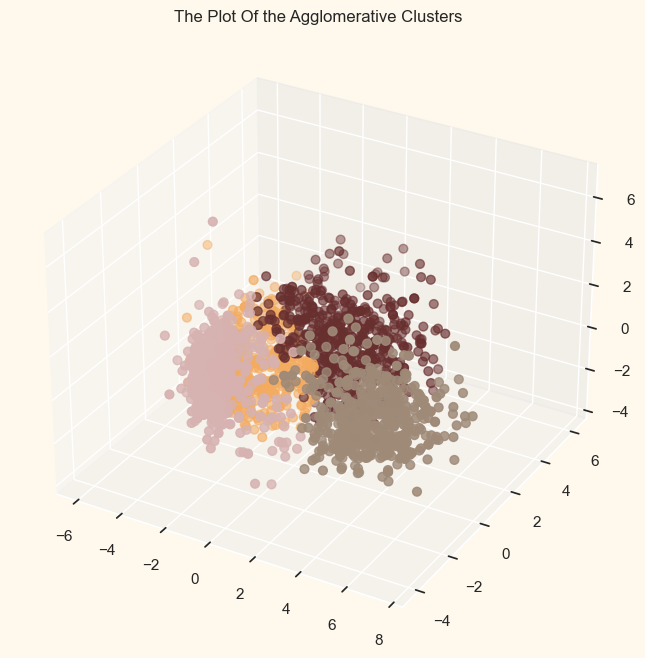

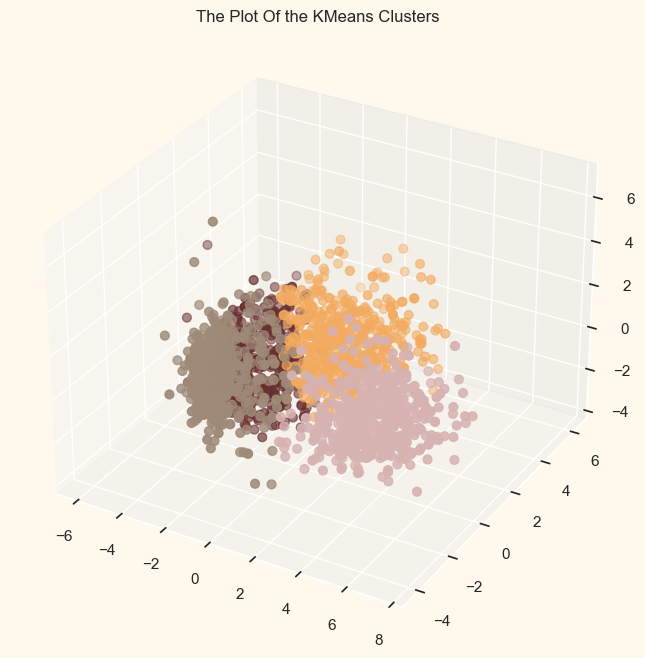

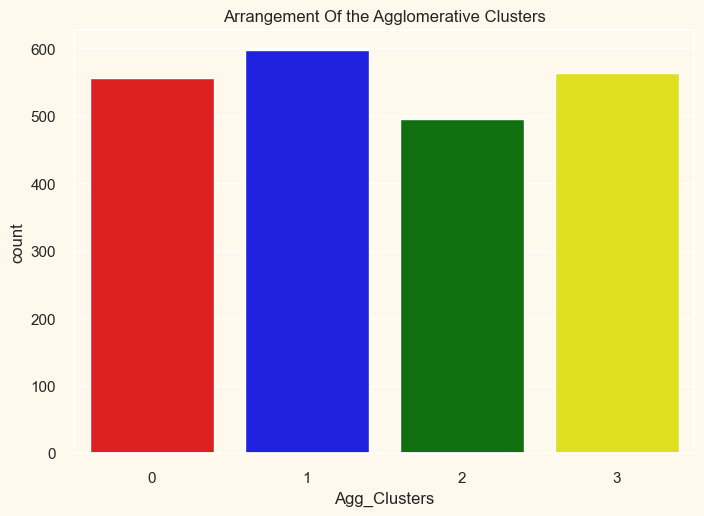

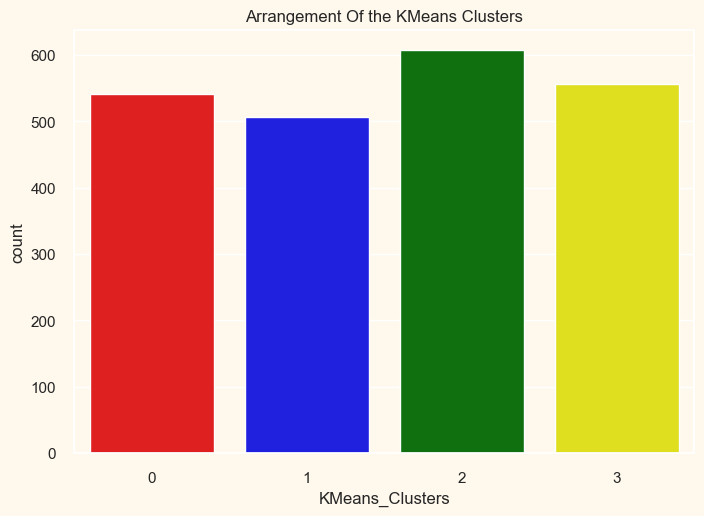

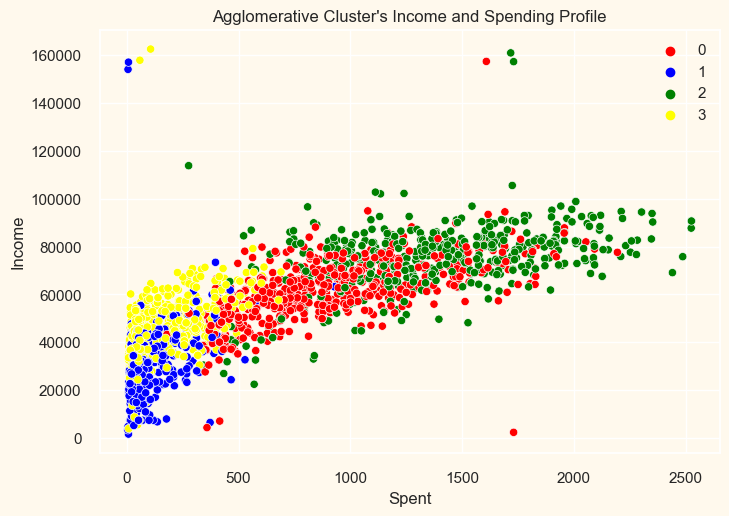

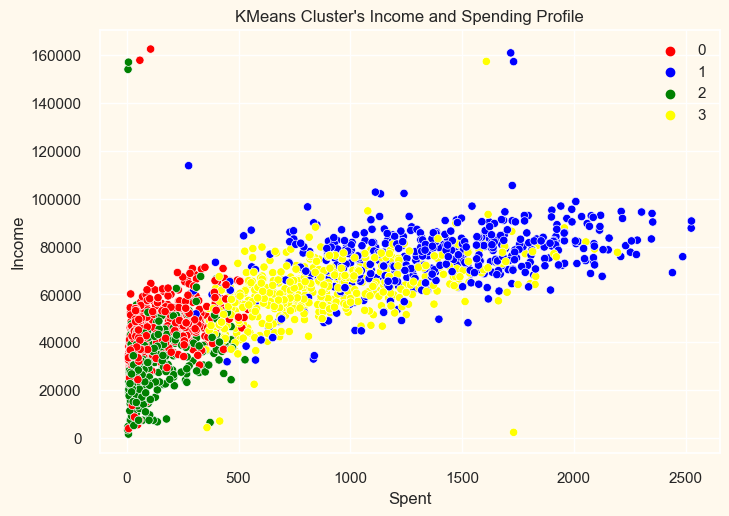

In [1]:
# Customer Segmentation using Agglomerative and K-means Clustering

### IMPORTING LIBRARIES
import numpy as np  
import pandas as pd  
import datetime  
import matplotlib  
import matplotlib.pyplot as plt  
from matplotlib import colors  
import seaborn as sns  
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA  
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans  
from sklearn.cluster import AgglomerativeClustering  
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap  
import warnings  
import sys  
import time

if not sys.warnoptions:  
    warnings.simplefilter("ignore")  
np.random.seed(42)  

!pip install yellowbrick

### LOADING DATA

dataset = pd.read_csv('marketing_campaign.csv', delimiter=';')
print("Number of datapoints in the dataset:", len(dataset))  
dataset.head()  

dataset.info()  

dataset = dataset.dropna()  

dataset["Dt_Customer"] = pd.to_datetime(dataset["Dt_Customer"])  
dates = []  
for i in dataset["Dt_Customer"]:  
    ii = i.date()  
    dates.append(i)    
# Dates of the most recent and oldest client enrollments on record  
newest_date = max(dates)  
print(f"Date of the most recent customer's enrollment in the records: {newest_date}")  
oldest_date = min(dates)  
print(f" Date of records' oldest customer's enrollment: {oldest_date}")  


#Created a feature "Customer_For_How_Much_Time"  
days = []  
d_1 = max(dates) #taking it to be the newest customer  
for i in dates:  
    d = d_1 - i  
    days.append(d)  
dataset["Customer_For_How_Much_Time"] = days  
dataset["Customer_For_How_Much_Time"] = pd.to_numeric(dataset["Customer_For_How_Much_Time"], errors="coerce")  

print("Total categories for the Marital Status feature:\n", dataset["Marital_Status"].value_counts(), "\n")  
print("Total categories for the feature Education:\n", dataset["Education"].value_counts())  

# Engineering Features  
#  Age of Customer till today  
dataset["Age"] = 2024-dataset["Year_Birth"]  
 
# Total spending on numerous products  
dataset["Spent"] = dataset["MntWines"]+ dataset["MntFruits"]+ dataset["MntMeatProducts"]+ dataset["MntFishProducts"]+ dataset["MntSweetProducts"]+ dataset["MntGoldProds"]  
 
# Living condition determined by marriage status "Alone"  
dataset["Living_With"]=dataset["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})  
 
# A feature that counts the number of kids in the home  
dataset["Children"]=dataset["Kidhome"]+dataset["Teenhome"]  
 
# Total number of household members feature  
dataset["Family_Size"] = dataset["Living_With"].replace({"Alone": 1, "Partner":2})+ dataset["Children"]  
 
# Feature related to parenting  
dataset["Is_Parent"] = np.where(dataset.Children> 0, 1, 0)  
 
# Dividing educational levels into three categories  
dataset["Education"]=dataset["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})  
 
# For clarity  
dataset=dataset.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})  
 
# Removing some of the pointless features  
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]  
dataset = dataset.drop(to_drop, axis=1)  

dataset.describe()  

# to plot a few chosen features  
# establishing colour preferences  
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})  
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]  
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])  
#plotting the features that follow  
to_be_plotted = [ "Income", "Recency", "Customer_For_How_Much_Time", "Age", "Spent", "Is_Parent"]  
print("Relational Script of a Few Selected Features: A subset of data")  
plt.figure()  
sns.pairplot(dataset[to_be_plotted], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))  
#Taking hue  
plt.show()  

# removing the outliers by capping their income and age.  
dataset = dataset[(dataset["Age"]<90)]  
dataset = dataset[(dataset["Income"]<600000)]  
l=len(dataset)  
print( f"Following the elimination of the outliers, there are {l} numbers of data points:")

# Encode categorical variables
LE = LabelEncoder()
for column in dataset.select_dtypes(include=['object']).columns:
    dataset[column] = LE.fit_transform(dataset[column])

# Calculating the correlation matrix
corrmat = dataset.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)

## Data Preprocessing

# Obtain a list of the category variables  
s = (dataset.dtypes == 'object')  
object_columns = list(s[s].index)  
 
print("the dataset's categorical variables are:", object_columns)  

# The object dtypes are label encoded.  
LE=LabelEncoder()  
for i in object_columns:  
    dataset[i]=dataset[[i]].apply(LE.fit_transform)  
     
print("Now, all attributes are numerical.")  

# making a duplicate of the data  
copy_dataset = dataset.copy()  
# Removing the features on deals accepted and promotions to create a subset of the dataframe  
columns_to_delete = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']  
copy_dataset = copy_dataset.drop(columns_to_delete, axis=1)  
# Scaling  
standard_scaler = StandardScaler()  
standard_scaler.fit(copy_dataset)  
scaled_dataset = pd.DataFrame(standard_scaler.transform(copy_dataset),columns= copy_dataset.columns )  
print(" Now, every feature is scaled ")  

# Using scaled data to reduce the dimensionality  
print("Dataframe to be applied in further modelling:")  
scaled_dataset.head()  

## Dimensionality Reduction

#### PCA-based dimension reduction
#### Graphing the compressed dataframe

#Initiating PCA to reduce dimensions, aka features, to 3  
pca = PCA(n_components=3)  
pca.fit(scaled_dataset)  
PCA_dataset = pd.DataFrame(pca.transform(scaled_dataset), columns=(["col1","col2", "col3"]))  
PCA_dataset.describe().T  

#A Reduced Dimensional 3D Data Projection  
x =PCA_dataset["col1"]  
y =PCA_dataset["col2"]  
z =PCA_dataset["col3"]  
# To plot  
fig = plt.figure(figsize=(10,8))  
ax = fig.add_subplot(111, projection="3d")  
ax.scatter(x,y,z, c="blue", marker="o" )  
ax.set_title("A Reduced Dimensional 3D Data Projection")  
plt.show()  

## Clustering

#### Determine the number of clusters to build using the elbow method.
#### Agglomerative Clustering for Clustering
#### examining the scatter plot clusters that were created

# Elbow technique to determine how many clusters to create.  
print('The amount of clusters to generate will be determined using the elbow method:')  
Elbow_method = KElbowVisualizer(KMeans(), k=10)  
Elbow_method.fit(PCA_dataset)  
Elbow_method.show()  

# Agglomerative Clustering model launch  
aggCluster = AgglomerativeClustering(n_clusters=4)  

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)

start_time = time.time()
# model fitting and cluster prediction for Agglomerative Clustering
yhat_aggCluster = aggCluster.fit_predict(PCA_dataset)
agg_execution_time = time.time() - start_time

start_time = time.time()
# model fitting and cluster prediction for K-means
yhat_kmeans = kmeans.fit_predict(PCA_dataset)
kmeans_execution_time = time.time() - start_time

# Calculate silhouette scores
silhouette_agg = silhouette_score(PCA_dataset, yhat_aggCluster)
silhouette_kmeans = silhouette_score(PCA_dataset, yhat_kmeans)

print("Silhouette Score for Agglomerative Clustering:", silhouette_agg)
print("Silhouette Score for K-means Clustering:", silhouette_kmeans)
print("Execution Time for Agglomerative Clustering:", agg_execution_time)
print("Execution Time for K-means Clustering:", kmeans_execution_time)

PCA_dataset["Agg_Clusters"] = yhat_aggCluster
PCA_dataset["KMeans_Clusters"] = yhat_kmeans

# The original dataframe is updated with the Clusters feature.  
dataset["Agg_Clusters"]= yhat_aggCluster
dataset["KMeans_Clusters"]= yhat_kmeans

# Plotting the clusters for Agglomerative Clustering
fig = plt.figure(figsize=(10,8))  
ax = plt.subplot(111, projection='3d', label="bla")  
ax.scatter(x, y, z, s=40, c=PCA_dataset["Agg_Clusters"], marker='o', cmap = cmap )  
ax.set_title("The Plot Of the Agglomerative Clusters")  
plt.show()  

# Plotting the clusters for K-means Clustering
fig = plt.figure(figsize=(10,8))  
ax = plt.subplot(111, projection='3d', label="bla")  
ax.scatter(x, y, z, s=40, c=PCA_dataset["KMeans_Clusters"], marker='o', cmap = cmap )  
ax.set_title("The Plot Of the KMeans Clusters")  
plt.show()  

## Evaluation Models

#Plotting countplot of clusters for Agglomerative Clustering
plt.figure()  
pal = ["red","blue", "green","yellow"]
pl = sns.countplot(x=dataset["Agg_Clusters"], palette= pal)  
pl.set_title("Arrangement Of the Agglomerative Clusters")  
plt.show()  

#Plotting countplot of clusters for K-means Clustering
plt.figure()  
pl = sns.countplot(x=dataset["KMeans_Clusters"], palette= pal)  
pl.set_title("Arrangement Of the KMeans Clusters")  
plt.show()  

#Plotting cluster's income and spending profile for Agglomerative Clustering
plt.figure()  
pl = sns.scatterplot(data = dataset,x=dataset["Spent"], y=dataset["Income"],hue=dataset["Agg_Clusters"], palette= pal)  
pl.set_title("Agglomerative Cluster's Income and Spending Profile")  
plt.legend()  
plt.show()  

#Plotting cluster's income and spending profile for K-means Clustering
plt.figure()  
pl = sns.scatterplot(data = dataset,x=dataset["Spent"], y=dataset["Income"],hue=dataset["KMeans_Clusters"], palette= pal)  
pl.set_title("KMeans Cluster's Income and Spending Profile")  
plt.legend()  
plt.show()  

# Additional plots and analysis for Agglomerative Clustering can be added in a similar manner as for K-means Clustering